# TODO

- 特徴量によって最適なloss weightが異なるので，チューニングしながらCVを返す関数を作る
- スコアが上がる特徴量と下がる特徴量を判定する関数を作る -> exp23でやる
- 特徴量エンジニアリング
    - ゆうだいさんの特徴量に合わせる
- Base Line
    - Model: LogLoss + Loss weight
    - CV: 0.6715182916909637
    - LB: 0.6700798

# Setting

In [1]:
import sys

import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Final

root_dir = "../../"
if root_dir not in sys.path:
    sys.path.append(root_dir)
from modules import config as cfg
from modules import utils, preprosess, training, predict, metrics, workflow

exp = "exp21"
utils.set_seed(cfg.Params.seed)

# Read data

In [2]:
train, test, submit = utils.get_data(debug_mode=False)

# Preprocessing

## Split fold

In [3]:
train = preprosess.assign_stratified_k_fold(train)

## Convert

In [4]:
#train

In [5]:
# testのBankStateの"PR"はtrainにないため，一番多いCAに変換
test = test.with_columns(pl.col("BankState").str.replace("PR", "CA"))

# 地名を座標に変換
train = preprosess.convert_to_latlon(train)
test  = preprosess.convert_to_latlon(test)

# DisbursementDateとApprovalDateを数値に変換
cols  = ["DisbursementDate", "ApprovalDate"]
train = preprosess.convert_date_to_year(train, cols)
test  = preprosess.convert_date_to_year(test, cols)
train = preprosess.convert_date_to_month(train, cols)
test  = preprosess.convert_date_to_month(test, cols)
train = preprosess.convert_date_to_day(train, cols)
test  = preprosess.convert_date_to_day(test, cols)

# 金額データの数値化
cols  = ["DisbursementGross",  "GrAppv", "SBA_Appv"]
train = preprosess.convert_money_data(train, cols)
test  = preprosess.convert_money_data(test, cols)

# 一致しているか
eqs = [
    ["State", "BankState"],
]
train = preprosess.add_eq(train, eqs)
test  = preprosess.add_eq(test, eqs)

# DisbursementDateとApprovalDateの差を計算
train = preprosess.add_diff_disbursement_with_approval(train)
test  = preprosess.add_diff_disbursement_with_approval(test)

# Sectorを職業別にする
train = preprosess.unify_same_sector(train)
test  = preprosess.unify_same_sector(test)

# ラベルデータをSBA_Appvの統計量で置き換える
AGG_NAME: Final[list] = ["mean", "median", "max", "min"]
AGG_COL: Final[str] = "SBA_Appv"
VS_AGG_COLS: Final[list] = [
    'NewExist', 
    'RevLineCr', 
    'LowDoc', 
    'UrbanRural', 
    'CreateJob'
]
train, test = preprosess.convert_aggregation_data(train, test, AGG_COL, VS_AGG_COLS)

# 差の計算
diffs = [
    ["DisbursementGross", "GrAppv"],   # 支払われた額 vs 銀行承認額
    ["DisbursementGross", "SBA_Appv"], # 支払われた額 vs SBA承認額
    ["GrAppv", "SBA_Appv"],            # 銀行承認額 vs SBA承認額
]

# ラベルデータをSBA_Appvの統計量で置き換えたもの vs SBA_Appv
for col_name in VS_AGG_COLS:
    for name in AGG_NAME:
        diff = [AGG_COL, f"{col_name}_{AGG_COL}_{name}"]
        diffs.append(diff)

train = preprosess.add_diff(train, diffs)
test  = preprosess.add_diff(test, diffs)

# 割合の計算
divs = [
    ["DisbursementGross", "Term"],
    ["GrAppv", "Term"],
    ["SBA_Appv", "Term"],
    ["NoEmp", "Term"],
    ["DisbursementGross", "NoEmp"],
    ["GrAppv", "NoEmp"],
    ["SBA_Appv", "NoEmp"],
    ["DisbursementGross_GrAppv_diff", "Term"],
    ["DisbursementGross_SBA_Appv_diff", "Term"],
    ["GrAppv_SBA_Appv_diff", "Term"],
    ["DisbursementGross_GrAppv_diff", "NoEmp"],
    ["DisbursementGross_SBA_Appv_diff", "NoEmp"],
    ["GrAppv_SBA_Appv_diff", "NoEmp"]
]
train = preprosess.add_div(train, divs)
test  = preprosess.add_div(test, divs)

## Target encoding

In [7]:
cols = [
    # "Sector",
    "UrbanRural",
    "RevLineCr",
    "LowDoc",
    "FranchiseCode",
]
target_col = "MIS_Status"
train, test = preprosess.target_encoding(train, test, cols)

## Label encoding
CVによるtarget encodingでは同じカテゴリカル変数に異なる値が割り当てられるのでlabel encodingを併用する

In [8]:
cols = ["RevLineCr", "LowDoc"]
train, test = preprosess.label_encoding(train, test, cols)

# Drop columns

In [9]:
# 不要なカラムの削除
del_cols = [
    # 地名系
    "City",
    "State",
    "BankState",
    # d-b-y系
    "DisbursementDate",
    "ApprovalDate",
    "ApprovalFY",
    # ラベルエンコーディング済み
    "RevLineCr",
    "LowDoc",
]

for col_name in VS_AGG_COLS:
    for name in AGG_NAME:
        del_cols.append(f"{col_name}_{AGG_COL}_{name}")

train = train.drop(del_cols)
test  = test.drop(del_cols)

# Training

In [10]:
utils.ignore_user_warning()

In [11]:
lgb_params = {
    'objective': 'binary',
    'metric': 'custom',
    'boosting_type': 'gbdt',
    'seed': cfg.Params.seed,
    'learning_rate': cfg.Params.learning_rate,
}
zero_weights = np.arange(0.74, 0.87, 0.01)

In [12]:
_, best_zero_weight = workflow.tuning_loss_weight(train, lgb_params=lgb_params, zero_weights=zero_weights)

--------------------------------------------------------------------------------
START fold 1
[LightGBM] [Info] Number of positive: 30213, number of negative: 3632
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.111147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12219
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.745076 -> initscore=1.072520
[LightGBM] [Info] Start training from score 1.072520
Training until validation scores don't improve for 200 rounds
[100]	training's macro_f1: 0.650333	valid_1's macro_f1: 0.657576
Did not meet early stopping. Best iteration is:
[100]	training's macro_f1: 0.650333	valid_1's macro_f1: 0.657576
Time:  7.827[s]
--------------------------------------------------------------------------------
START fold

In [13]:
weight = [best_zero_weight, 1 - best_zero_weight]
print(f"weight: {weight}")
train = preprosess.add_loss_weight(train, weight)
oof, models = training.fit_lgbm(train, lgb_params=lgb_params)

--------------------------------------------------------------------------------
START fold 1
[LightGBM] [Info] Number of positive: 30213, number of negative: 3632
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12219
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.613076 -> initscore=0.460261
[LightGBM] [Info] Start training from score 0.460261
Training until validation scores don't improve for 200 rounds
[100]	training's macro_f1: 0.684171	valid_1's macro_f1: 0.685551
Did not meet early stopping. Best iteration is:
[94]	training's macro_f1: 0.684949	valid_1's macro_f1: 0.686206
Time:  13.883[s]
--------------------------------------------------------------------------------
START fold 2
[LightGBM] [Info] Number of positive: 30213, number of negati

# Predict

In [23]:
threshold = 0.5

## CV score

In [26]:
oof_truth = train[cfg.Cols.target].to_numpy()
oof_hat = predict.predict_class(oof, threshold=threshold)
cv_score = metrics.macro_f1_score(oof_truth, oof_hat)
print(cv_score)

0.6732937032808918


## Test prediction

In [27]:
pred_prob = predict.predict_probability(models, test)
pred_class = predict.predict_class(pred_prob, threshold=threshold)

## Check result

### oofとtestの予測値分布を比較してバグを確認

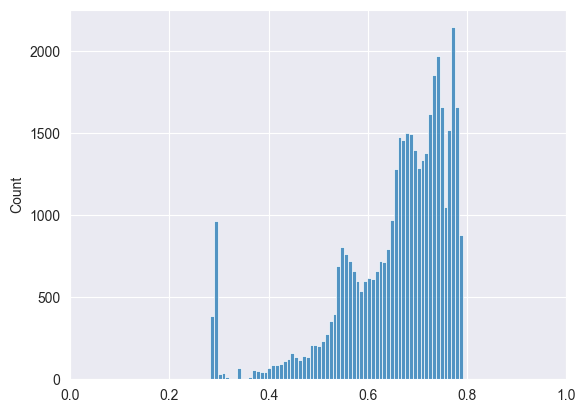

In [28]:
sns.histplot(pred_prob)
plt.xlim(0.0, 1.0)
plt.show()

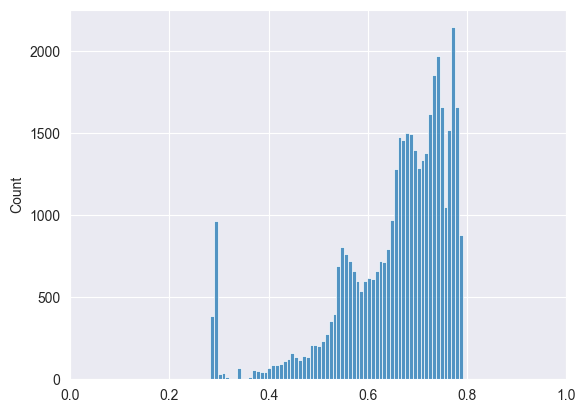

In [30]:
sns.histplot(pred_prob)
plt.xlim(0.0, 1.0)
plt.show()

### 予測値の1の割合を確認

In [31]:
print(pred_class.sum() / len(pred_class))

0.91840786612461


### oofにおける混同行列を確認

True Negative Rate (0の正解率): 0.36
True Positive Rate (1の正解率): 0.95


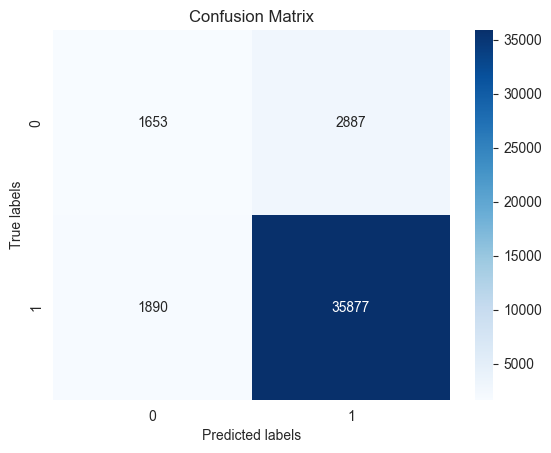

In [32]:
metrics.show_confusion_matrix(oof_truth, oof_hat)

## Submit

In [33]:
submit = submit.with_columns([pl.Series(cfg.Cols.sub_pred, pred_class)])
utils.make_submission(submit, exp, cv_score)